# Usage (quick version)

## Preparation

In [1]:
# Standard users
# !pip install covsirphy
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [2]:
import warnings

In [3]:
import covsirphy as cs
cs.__version__

'2.8.1-alpha.fix.211'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/


Detailed citaition list:

Open Government Data, United Kingdom (2020), https://coronavirus.data.gov.uk
World Health Organization (2020), https://covid19.who.int
The COVID Tracking Project (2020), https://covidtracking.com
Open Government Data, Latvia (2020), https://data.gov.lv/dati/dataset
Wikipedia (2020), https://en.wikipedia.org/wiki
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be
Johns Hopkins Center for Systems Science and Engineering (2020), https://github.com/CSSEGISandData/COVID-19
Covid19data.com.au (2020), https://github.com/M3IT/COVID-19_Data
Data Science for Social Impact research group, University of Pretoria (2020), https://github.com/dsfsi/covid19za
COVID-19_plus_Russia GitHub repository (2020), https://github.com/grwlf/COVID-19_plus_Russia
COVID-19 Peru Data Repository (2020), https://github.com/jmcastagnetto/covid-19-peru-data
The New York Times (2020), https://github.com/nytimes/covid-19-data
Open Government Data, Liechtenstein (2020), https://github.com/openZH/covid

### The number of cases (JHU style)

In [5]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [6]:
print(data_loader.covid19dh_citation)

Open Government Data, United Kingdom (2020), https://coronavirus.data.gov.uk
World Health Organization (2020), https://covid19.who.int
The COVID Tracking Project (2020), https://covidtracking.com
Open Government Data, Latvia (2020), https://data.gov.lv/dati/dataset
Wikipedia (2020), https://en.wikipedia.org/wiki
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be
Johns Hopkins Center for Systems Science and Engineering (2020), https://github.com/CSSEGISandData/COVID-19
Covid19data.com.au (2020), https://github.com/M3IT/COVID-19_Data
Data Science for Social Impact research group, University of Pretoria (2020), https://github.com/dsfsi/covid19za
COVID-19_plus_Russia GitHub repository (2020), https://github.com/grwlf/COVID-19_plus_Russia
COVID-19 Peru Data Repository (2020), https://github.com/jmcastagnetto/covid-19-peru-data
The New York Times (2020), https://github.com/nytimes/covid-19-data
Open Government Data, Liechtenstein (2020), https://github.com/openZH/covid

In [7]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
196137,2020-08-31,14,12,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
196138,2020-09-01,14,12,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
196139,2020-09-02,14,14,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
196140,2020-09-03,14,14,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
196141,2020-09-04,14,14,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [8]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
196137,2020-08-31,Colombia,Vichada,14,2,0,12
196138,2020-09-01,Colombia,Vichada,14,2,0,12
196139,2020-09-02,Colombia,Vichada,14,0,0,14
196140,2020-09-03,Colombia,Vichada,14,0,0,14
196141,2020-09-04,Colombia,Vichada,14,0,0,14


In [9]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
165,2020-08-31,20817,2784,363,17670
166,2020-09-01,20987,2764,364,17859
167,2020-09-02,21128,2706,364,18058
168,2020-09-03,21339,2735,365,18239
169,2020-09-04,21475,2619,369,18487


In [10]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-08-31,25110908,7762395,841280,16507233,0.016751,0.328687,0.048493
2020-09-01,25366012,7765476,847385,16753151,0.016703,0.330228,0.048145
2020-09-02,25636978,7819502,853143,16964333,0.016639,0.330857,0.047882
2020-09-03,25907704,7863905,858488,17185311,0.016568,0.331664,0.047578
2020-09-04,25908329,7863286,858507,17186536,0.016568,0.331680,0.047576


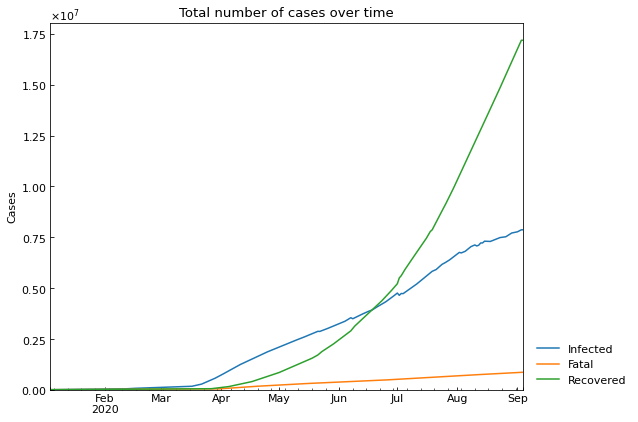

In [11]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan


In [12]:
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
204,2020-08-31,68430,10344,1299,56787
205,2020-09-01,69063,9933,1314,57816
206,2020-09-02,69657,9911,1327,58419
207,2020-09-03,70315,9463,1335,59517
208,2020-09-04,70901,9149,1352,60400


In [13]:
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan

In [14]:
jhu_data.replace(japan_data)
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
202,2020-08-31,67865,9784,1279,56802
203,2020-09-01,68392,9273,1296,57823
204,2020-09-02,69001,9266,1307,58428
205,2020-09-03,69599,8756,1319,59524
206,2020-09-04,70268,8521,1330,60417


### Population in each country

In [15]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [16]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
196137,2020-08-31,14,12,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
196138,2020-09-01,14,12,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
196139,2020-09-02,14,14,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
196140,2020-09-03,14,14,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
196141,2020-09-04,14,14,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [17]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Date,Population
192393,COL,Colombia,Vichada,2020-08-31,107808
192394,COL,Colombia,Vichada,2020-09-01,107808
192395,COL,Colombia,Vichada,2020-09-02,107808
192396,COL,Colombia,Vichada,2020-09-03,107808
192397,COL,Colombia,Vichada,2020-09-04,107808


In [18]:
population_data.value("Japan", province=None)

126529100

In [19]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)

In [20]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [21]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
196137,2020-08-31,14,12,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
196138,2020-09-01,14,12,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
196139,2020-09-02,14,14,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
196140,2020-09-03,14,14,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
196141,2020-09-04,14,14,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [22]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
196137,2020-08-31,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
196138,2020-09-01,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
196139,2020-09-02,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
196140,2020-09-03,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
196141,2020-09-04,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04


In [23]:
# Subset for a country
oxcgrt_data.subset("Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
240,2020-08-31,1,1,1,0,0,1,1,3,2,2,1,30.56
241,2020-09-01,1,1,1,0,0,1,1,3,2,2,1,30.56
242,2020-09-02,1,1,1,0,0,1,1,3,2,2,1,30.56
243,2020-09-03,1,1,1,0,0,1,1,3,2,2,1,30.56
244,2020-09-04,1,1,1,0,0,1,1,3,2,2,1,30.56


In [24]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset("JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
240,2020-08-31,1,1,1,0,0,1,1,3,2,2,1,30.56
241,2020-09-01,1,1,1,0,0,1,1,3,2,2,1,30.56
242,2020-09-02,1,1,1,0,0,1,1,3,2,2,1,30.56
243,2020-09-03,1,1,1,0,0,1,1,3,2,2,1,30.56
244,2020-09-04,1,1,1,0,0,1,1,3,2,2,1,30.56


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [25]:
scenario = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records

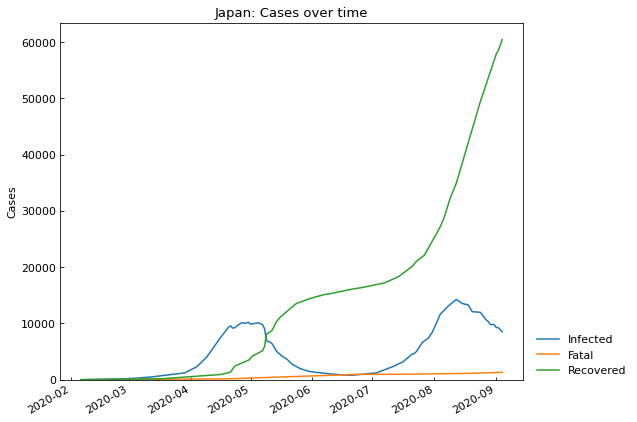

,Date,Confirmed,Infected,Fatal,Recovered
202,2020-08-31,67865,9784,1279,56802
203,2020-09-01,68392,9273,1296,57823
204,2020-09-02,69001,9266,1307,58428
205,2020-09-03,69599,8756,1319,59524
206,2020-09-04,70268,8521,1330,60417


In [26]:
import matplotlib
warnings.simplefilter("ignore", category=matplotlib.MatplotlibDeprecationWarning)
record_df = scenario.records()
record_df.tail()

### S-R trend analysis

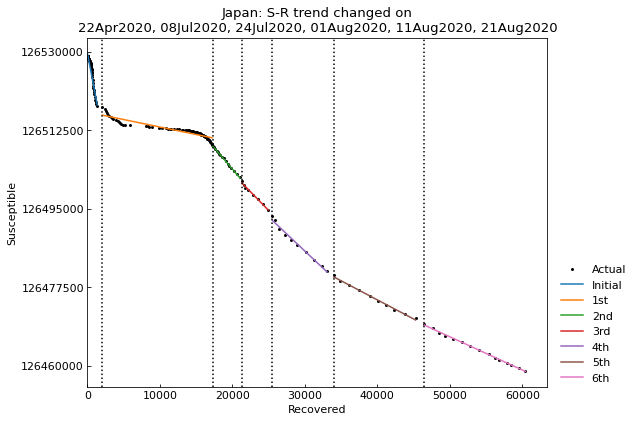

,Type,Start,End,Population
1st,Past,22Apr2020,07Jul2020,126529100
2nd,Past,08Jul2020,23Jul2020,126529100
3rd,Past,24Jul2020,31Jul2020,126529100
4th,Past,01Aug2020,10Aug2020,126529100
5th,Past,11Aug2020,20Aug2020,126529100
6th,Past,21Aug2020,04Sep2020,126529100


In [27]:
scenario.trend(set_phases=True)
scenario.summary()

### Hyperparameter estimation of ODE models
As an example, use SIR-F model.
We can use SIR, SIRD, (SIRFV), (SEWIRF).

In [28]:
scenario.estimate(cs.SIRF)


<SIR-F model: parameter estimation>

Running optimization with 4 CPUs...

	6th phase (21Aug2020 - 04Sep2020): finished  320 trials in 0 min 10 sec

	3rd phase (24Jul2020 - 31Jul2020): finished 1044 trials in 0 min 25 sec

	4th phase (01Aug2020 - 10Aug2020): finished 1755 trials in 1 min  0 sec

	1st phase (22Apr2020 - 07Jul2020): finished 1637 trials in 1 min  0 sec

	2nd phase (08Jul2020 - 23Jul2020): finished 1729 trials in 1 min  0 sec

	5th phase (11Aug2020 - 20Aug2020): finished 1741 trials in 1 min  0 sec

Completed optimization. Total: 1 min 36 sec

In [29]:
scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/alpha2 [day],1/beta [day],alpha1 [-],1/gamma [day],RMSLE,Trials,Runtime
1st,Past,22Apr2020,07Jul2020,126529100,SIR-F,0.45,0.054986,0.000256,0.007124,0.014822,288,780,28,0.055,13,1.020902,1637,1 min 0 sec
2nd,Past,08Jul2020,23Jul2020,126529100,SIR-F,1.91,0.000679,0.000021,0.028695,0.015015,288,9398,6,0.001,13,0.027987,1729,1 min 0 sec
3rd,Past,24Jul2020,31Jul2020,126529100,SIR-F,1.80,0.000678,0.000021,0.026130,0.014495,288,9401,7,0.001,13,0.017278,1044,0 min 25 sec
4th,Past,01Aug2020,10Aug2020,126529100,SIR-F,1.74,0.000628,0.000072,0.021069,0.012064,288,2790,9,0.001,16,0.040872,1755,1 min 0 sec
5th,Past,11Aug2020,20Aug2020,126529100,SIR-F,0.85,0.000489,0.000106,0.016248,0.019068,288,1890,12,0.000,10,0.026136,1741,1 min 0 sec
6th,Past,21Aug2020,04Sep2020,126529100,SIR-F,0.71,0.000572,0.000242,0.013887,0.019409,288,827,14,0.001,10,0.045540,320,0 min 10 sec


### Accuracy of estimation

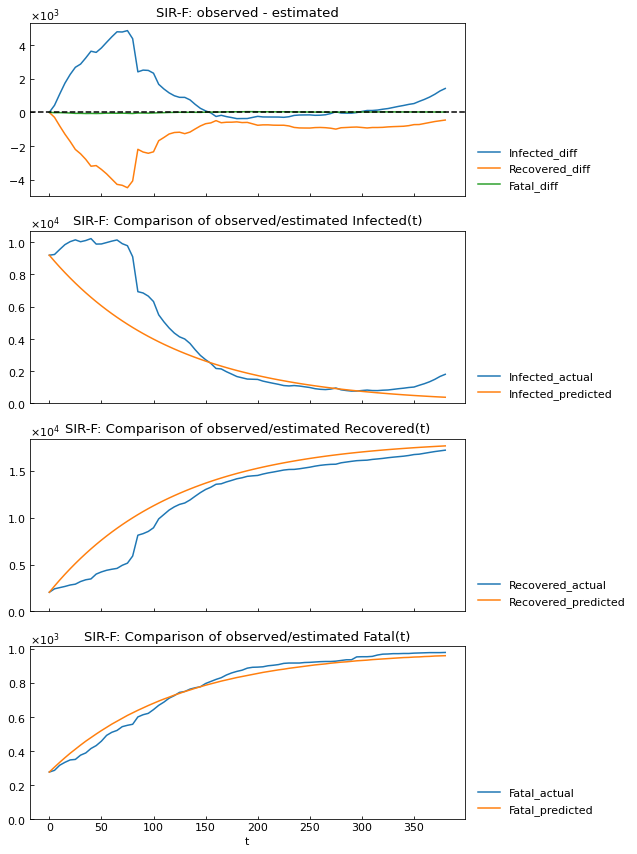

In [30]:
scenario.estimate_accuracy(phase="1st")

### Get parameter value

In [31]:
scenario.get("Rt", phase="4th")

1.74

### Show parameter history

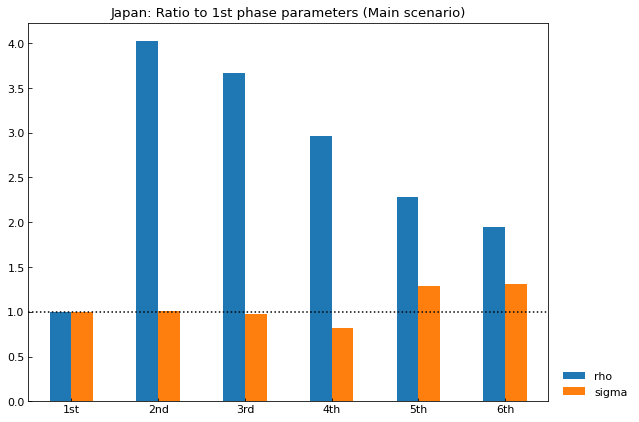

,1st,2nd,3rd,4th,5th,6th
rho,1.0,4.028214,3.668063,2.957597,2.280921,1.949410
sigma,1.0,1.013025,0.977921,0.813912,1.286488,1.309447


In [32]:
df = scenario.param_history(targets=["rho", "sigma"])
df.T

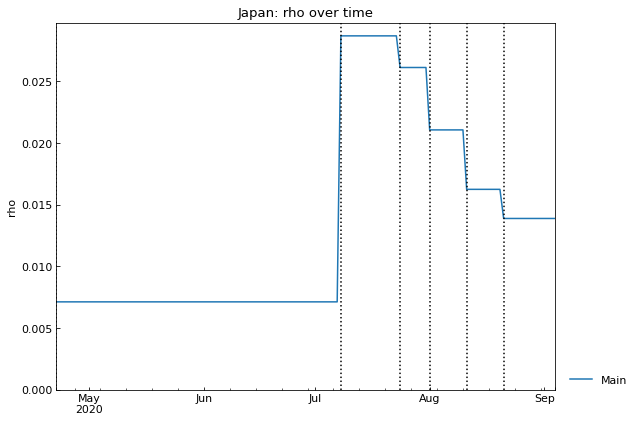

In [33]:
# version >= 2.8.0
_ = scenario.history(target="rho")

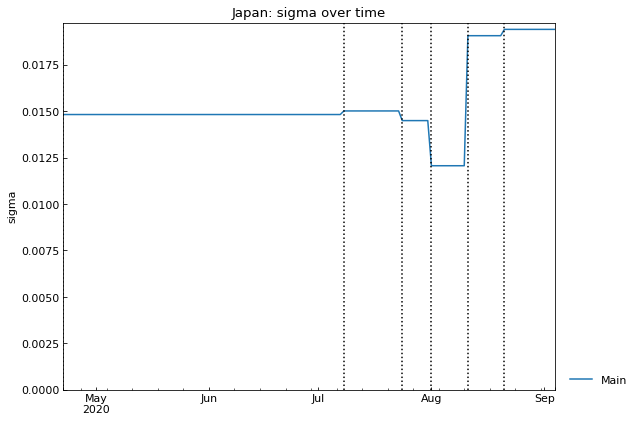

In [34]:
# version >= 2.8.0
_ = scenario.history(target="sigma")

### Show the history of reproduction number

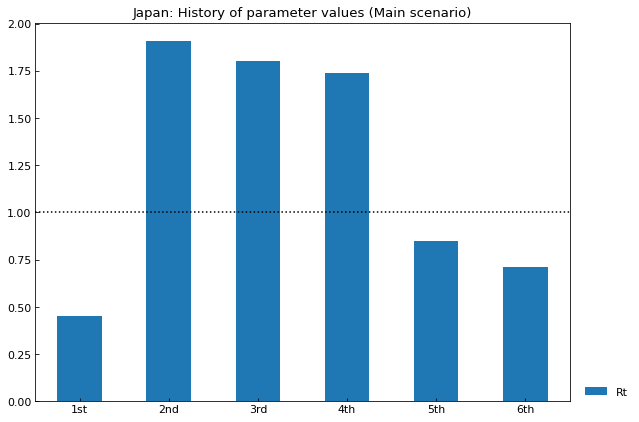

,1st,2nd,3rd,4th,5th,6th
Rt,0.45,1.91,1.8,1.74,0.85,0.71


In [35]:
df = scenario.param_history(targets=["Rt"], divide_by_first=False, show_box_plot=True)
df.T

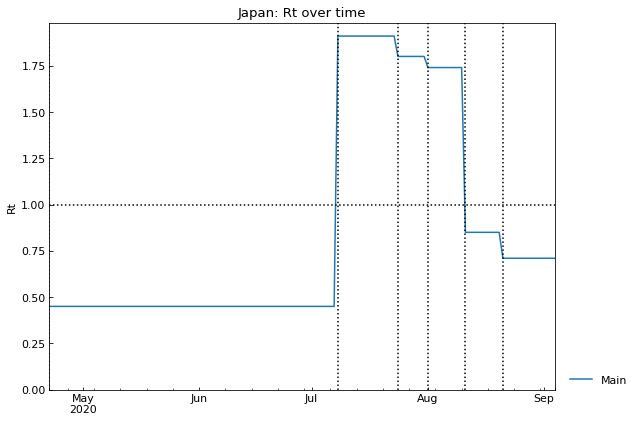

In [36]:
# version >= 2.8.0
_ = scenario.history(target="Rt")

### Simulate the number of cases

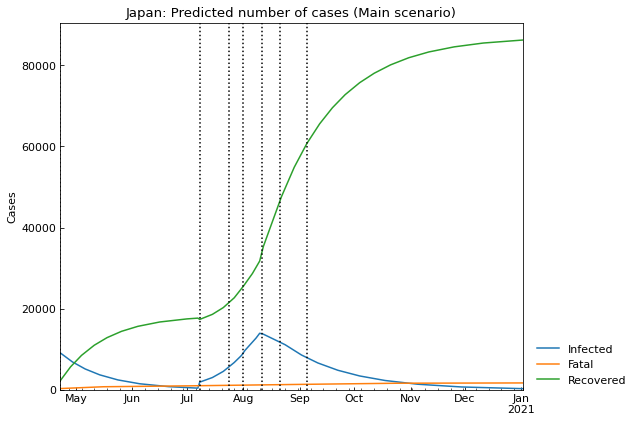

,Date,Confirmed,Fatal,Infected,Recovered
251,2020-12-29,88095,1666,284,86145
252,2020-12-30,88114,1666,276,86172
253,2020-12-31,88132,1666,268,86198
254,2021-01-01,88151,1667,260,86224
255,2021-01-02,88169,1667,253,86249


In [37]:
scenario.clear(name="Main")
scenario.add(end_date="01Jan2021", name="Main")
main_sim_df = scenario.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [38]:
sigma_current = scenario.get("sigma", name="Main", phase="last")
sigma_current

0.019408661121733634

In [39]:
sigma_new = sigma_current * 2
sigma_new

0.03881732224346727

In [40]:
scenario.clear(name="Medicine")
scenario.add(name="Medicine", days=30, sigma=sigma_current)
scenario.add(name="Medicine", end_date="01Jan2021", sigma=sigma_new)
scenario.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario Phase                                                          
Main     1st      Past  22Apr2020  07Jul2020   126529100  SIR-F  0.45   
         2nd      Past  08Jul2020  23Jul2020   126529100  SIR-F  1.91   
         3rd      Past  24Jul2020  31Jul2020   126529100  SIR-F  1.80   
         4th      Past  01Aug2020  10Aug2020   126529100  SIR-F  1.74   
         5th      Past  11Aug2020  20Aug2020   126529100  SIR-F  0.85   
         6th      Past  21Aug2020  04Sep2020   126529100  SIR-F  0.71   
         7th    Future  05Sep2020  01Jan2021   126529100  SIR-F  0.71   
Medicine 1st      Past  22Apr2020  07Jul2020   126529100  SIR-F  0.45   
         2nd      Past  08Jul2020  23Jul2020   126529100  SIR-F  1.91   
         3rd      Past  24Jul2020  31Jul2020   126529100  SIR-F  1.80   
         4th      Past  01Aug2020  10Aug2020   126529100  SIR-F  1.74   
         5th      Past  11Aug2020  20Aug2020   126529100  SIR-F  0.85   
         6th      Past  21Aug2020  04Sep2020   126529100  SIR-F  0.71   
         7th    Future  05Sep2020  05Oct2020   126529100  SIR-F  0.71   
         8th    Future  06Oct2020  01Jan2021   126529100  SIR-F  0.36   

                   theta     kappa       rho     sigma  tau  1/alpha2 [day]  \
Scenario Phase                                                                
Main     1st    0.054986  0.000256  0.007124  0.014822  288             780   
         2nd    0.000679  0.000021  0.028695  0.015015  288            9398   
         3rd    0.000678  0.000021  0.026130  0.014495  288            9401   
         4th    0.000628  0.000072  0.021069  0.012064  288            2790   
         5th    0.000489  0.000106  0.016248  0.019068  288            1890   
         6th    0.000572  0.000242  0.013887  0.019409  288             827   
         7th    0.000572  0.000242  0.013887  0.019409  288             827   
Medicine 1st    0.054986  0.000256  0.007124  0.014822  288             780   
         2nd    0.000679  0.000021  0.028695  0.015015  288            9398   
         3rd    0.000678  0.000021  0.026130  0.014495  288            9401   
         4th    0.000628  0.000072  0.021069  0.012064  288            2790   
         5th    0.000489  0.000106  0.016248  0.019068  288            1890   
         6th    0.000572  0.000242  0.013887  0.019409  288             827   
         7th    0.000572  0.000242  0.013887  0.019409  288             827   
         8th    0.000572  0.000242  0.013887  0.038817  288             827   

                1/beta [day]  alpha1 [-]  1/gamma [day]      RMSLE Trials  \
Scenario Phase                                                              
Main     1st              28       0.055             13     1.0209   1637   
         2nd               6       0.001             13  0.0279874   1729   
         3rd               7       0.001             13   0.017278   1044   
         4th               9       0.001             16  0.0408717   1755   
         5th              12       0.000             10  0.0261357   1741   
         6th              14       0.001             10    0.04554    320   
         7th              14       0.001             10          -      -   
Medicine 1st              28       0.055             13     1.0209   1637   
         2nd               6       0.001             13  0.0279874   1729   
         3rd               7       0.001             13   0.017278   1044   
         4th               9       0.001             16  0.0408717   1755   
         5th              12       0.000             10  0.0261357   1741   
         6th              14       0.001             10    0.04554    320   
         7th              14       0.001             10          -      -   
         8th              14       0.001              5          -      -   

                     Runtime  
Scenario Phase                
Main     1st    1 min  0 sec  
         2nd    1 min  0 sec 

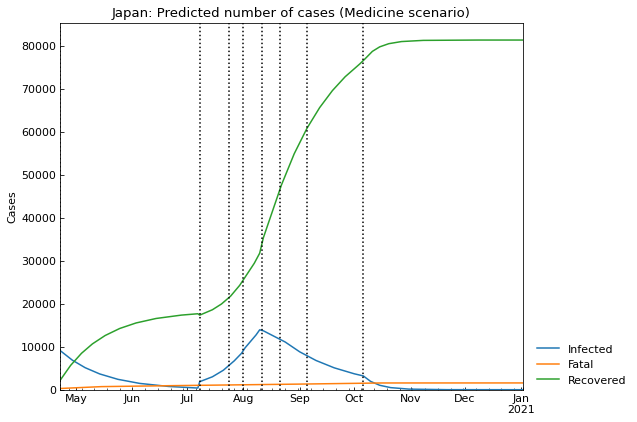

,Date,Confirmed,Fatal,Infected,Recovered
251,2020-12-29,82853,1572,0,81281
252,2020-12-30,82853,1572,0,81281
253,2020-12-31,82853,1572,0,81281
254,2021-01-01,82853,1572,0,81281
255,2021-01-02,82853,1572,0,81281


In [41]:
scenario.simulate(name="Medicine").tail()

### Compare the scenarios

In [42]:
scenario.describe()

,max(Infected),argmax(Infected),Infected on 02Jan2021,Fatal on 02Jan2021,8th_Rt
Main,13918,10Aug2020,253,1667,-
Medicine,13918,10Aug2020,0,1572,0.36


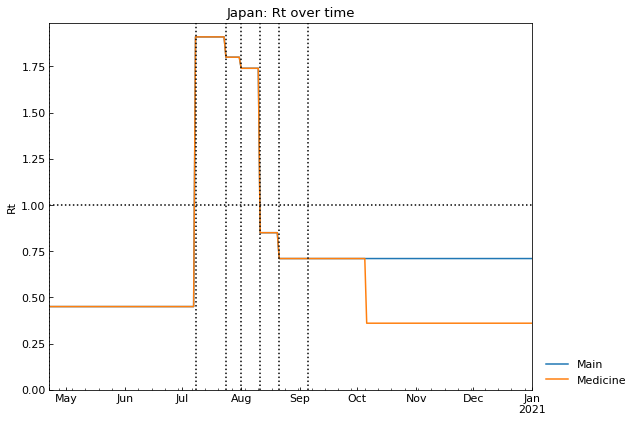

In [43]:
# version >= 2.8.0
_ = scenario.history(target="Rt")

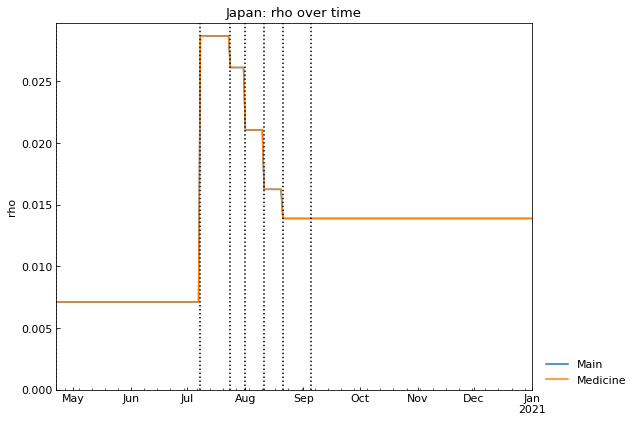

In [44]:
# version >= 2.8.0
_ = scenario.history(target="rho")

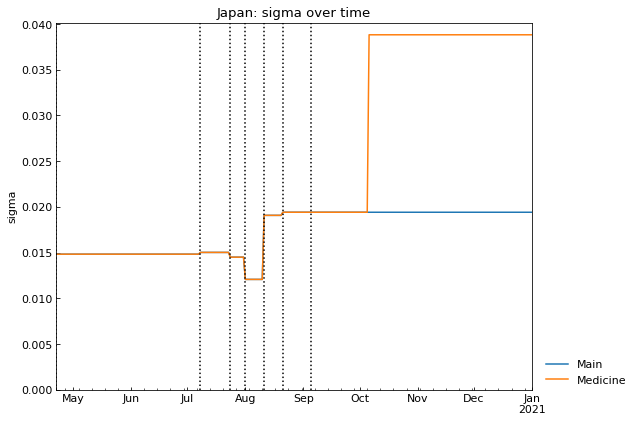

In [45]:
# version >= 2.8.0
_ = scenario.history(target="sigma")

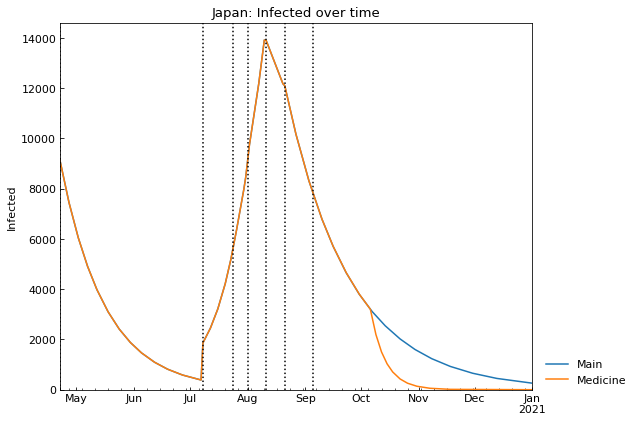

In [46]:
# version >= 2.8.0
_ = scenario.history(target="Infected")